# Overview of statistical inference

- frequency manipulation
- autocorrelation
- time-series decomposition
- stationarity tests

In [16]:
import pandas as pd
data_folder = "./data/"
crypto_df = pd.read_csv(data_folder + 'train.csv')

## Different frequency

- ohlc dataframe with differenct frequency.
- Single series with different frequency.

In [17]:
from script.morestats import ohlcv_with_frequency, ts_with_frequency
import plotly.graph_objects as go
btc = crypto_df[crypto_df["Asset_ID"]==1] # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:,:] # Select recent data row
print(btc_mini.head())

btc_mini=ohlcv_with_frequency(df=btc_mini,frequency='5min')
print(btc_mini.head())
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, 
                                    open=btc_mini['Open'], 
                                    high=btc_mini['High'], 
                                    low=btc_mini['Low'], 
                                    close=btc_mini['Close'])])
fig.show()

           timestamp  Asset_ID   Count          Open          High       Low  \
24234009  1632170460         1  5694.0  43558.393750  43588.680000  43427.28   
24234023  1632170520         1  2528.0  43449.818571  43495.954028  43414.33   
24234037  1632170580         1  3985.0  43427.082310  43455.218478  43327.29   
24234051  1632170640         1  2185.0  43362.572857  43454.990000  43348.06   
24234065  1632170700         1  2623.0  43419.832500  43467.000000  43351.15   

                 Close      Volume          VWAP    Target  
24234009  43447.003750  191.442881  43493.981877 -0.000805  
24234023  43440.000000   80.692018  43455.988146  0.000418  
24234037  43360.723750  117.332513  43391.956795  0.000125  
24234051  43427.242857   76.361478  43403.880056  0.000956  
24234065  43375.040000   76.018320  43408.267118 -0.000430  
              Count      Volume      High       Low          Open  \
timestamp                                                           
1632170400  143

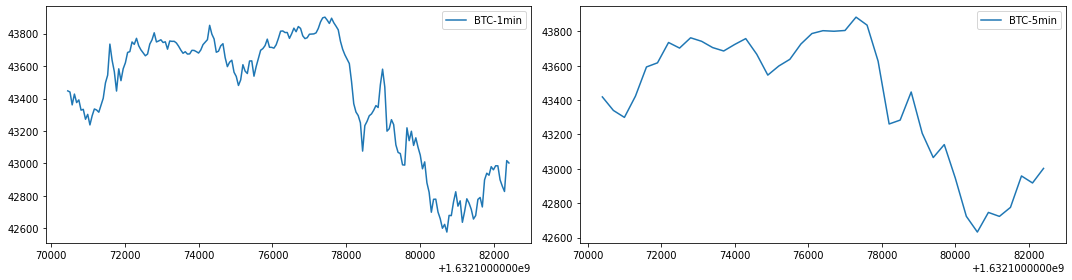

In [18]:
import matplotlib.pyplot as plt
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index('timestamp')
btc_mini = btc.iloc[-200:,:] # Select recent data row

f = plt.figure(figsize=(15,4))
ax = f.add_subplot(121)
plt.plot(btc_mini['Close'], label='BTC-1min')
plt.legend()

ax2 = f.add_subplot(122)
ax2.plot(ts_with_frequency(btc_mini['Close'], frequency='5min'), label='BTC-5min')
plt.legend()
plt.tight_layout()
plt.show()

## Autocorrelation 

$$s_{k}=\frac{1}{n} \sum_{i=1}^{n-k}\left(y_{i}-\bar{y}\right)\left(y_{i+k}-\bar{y}\right)=\frac{1}{n} \sum_{i=k+1}^{n}\left(y_{i}-\bar{y}\right)\left(y_{i-k}-\bar{y}\right)$$  

$$r_k = \frac{s_k}{s_0}$$

In [19]:
from matplotlib import pyplot
from script.morestats import log_return

Take 5-minute BTC("Asset_ID"=1) log return for example.

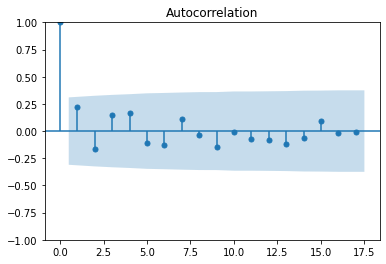

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from script.morestats import ts_with_frequency

ticker_id = 1
ticker = crypto_df[crypto_df["Asset_ID"]==ticker_id].set_index("timestamp") # Asset_ID = 1 for Bitcoin
ticker_mini = ticker.iloc[-200:] # Select recent 200 data rows
lret_ticker = log_return(ts_with_frequency(ticker_mini.Close, frequency='5min'))[1:]
plot_acf(lret_ticker)
pyplot.show()

In [21]:
from statsmodels.tsa.stattools import acf
acf(lret_ticker)

array([ 1.        ,  0.22300345, -0.16572461,  0.14992676,  0.16943098,
       -0.11037484, -0.12401055,  0.1126429 , -0.03998863, -0.14678928,
       -0.004823  , -0.07683669, -0.08140624, -0.12183986, -0.06091687,
        0.09130992, -0.0154014 ])

## Partial Autocorrelation
$$\frac{\operatorname{cov}\left(y_{i}, y_{i-h} \mid y_{i-1}, \ldots, y_{i-h+1}\right)}{\sqrt{\operatorname{var}\left(y_{i} \mid y_{i-1}, \ldots, y_{i-h+1}\right) \cdot \operatorname{var}\left(y_{i-h} \mid y_{i-1}, \ldots, y_{i-h+1}\right)}}$$

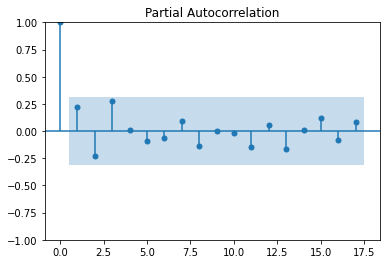

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(lret_ticker,method='ywm')
pyplot.show()

In [23]:
from statsmodels.tsa.stattools import pacf
pacf(lret_ticker)

array([ 1.        ,  0.22872149, -0.23927795,  0.29801839,  0.00751242,
       -0.11132402, -0.06900502,  0.11875178, -0.1780027 ,  0.00820432,
       -0.02724231, -0.21268755,  0.08472628, -0.26502616,  0.01981886,
        0.22023236, -0.19462007])

## Decomposition
- Time Series decomposition
- Wold Theorem

>>Given the obvious system dynamic change, we decompose the BTC series among a special growing period.

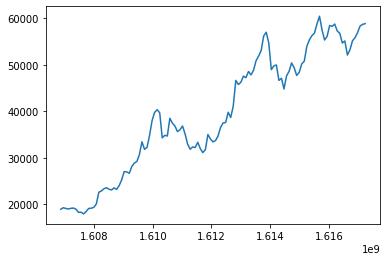

In [24]:
from script.morestats import d2s,ts_with_frequency
import matplotlib.pyplot as plt

btc = crypto_df[crypto_df["Asset_ID"]==1].set_index('timestamp')['Close']
btc_freq = ts_with_frequency(series=btc, frequency='1D')
plt.plot(btc_freq.loc[d2s('2020-12-01'):d2s('2021-04-01')])

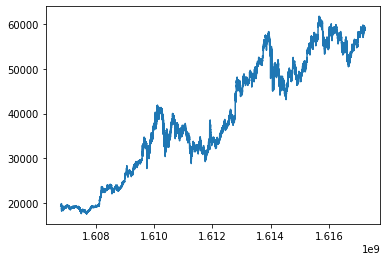

In [25]:
btc_freq = ts_with_frequency(series=btc, frequency='1min')
plt.plot(btc_freq.loc[d2s('2020-12-01'):d2s('2021-04-01')])

Any Periodical pattern?  

Try additive model below Seasonal+Trend+Residual.

$$y_{t}=S_{t}+T_{t}+R_{t}$$

Reference: [Forecasting: Principles and Practice](https://otexts.com/fpp2/components.html)

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from script.morestats import s2d
import numpy as np
btc_freq = ts_with_frequency(series=btc, frequency='1min')
btc_freq = btc_freq.loc[d2s('2020-12-01'):d2s('2021-04-01')]
btc_freq.index = [s2d(d) for d in btc_freq.index]

In [12]:
result = seasonal_decompose(x=btc_freq.dropna(), model='additive',period=60*24*7)#one week as a period

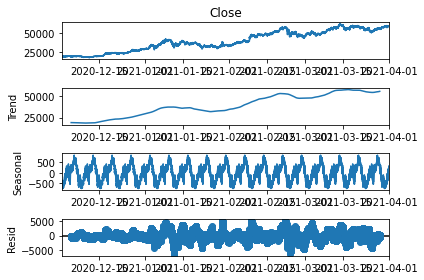

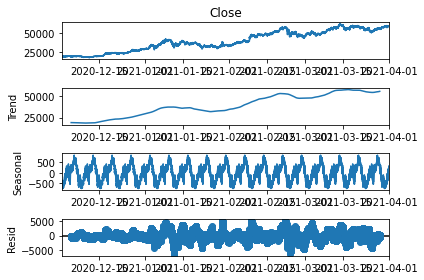

In [13]:
result.plot()

<AxesSubplot:>

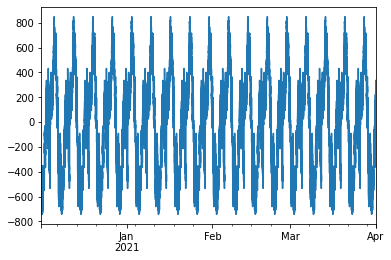

In [14]:
result.seasonal.plot()

<AxesSubplot:>

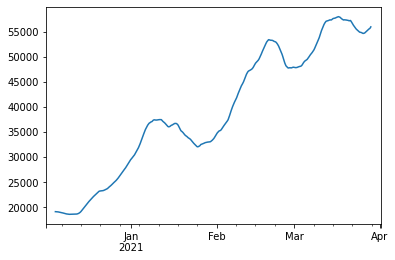

In [15]:
result.trend.plot()

## Stationarity Test